In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set visual style
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [4]:
# Load raw data
df = pd.read_csv(r"C:\Users\Hp\Projects\kaimtenx\solar-challenge-week1\data\benin-malanville.csv", parse_dates=["Timestamp"])
print(df.shape)
df.head()

(525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [5]:
# Summary statistics
df.describe()

# Missing values report
missing_report = df.isna().sum() / len(df) * 100
print("Columns with >5% missing values:")
missing_report[missing_report > 5]

Columns with >5% missing values:


Comments    100.0
dtype: float64

In [6]:

# Calculate Z-scores for key columns
outlier_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]

for col in outlier_cols:
    df[f"{col}_zscore"] = np.abs(stats.zscore(df[col], nan_policy='omit'))
    df[f"{col}_outlier"] = df[f"{col}_zscore"] > 3

# Count outliers
df[[f"{col}_outlier" for col in outlier_cols]].sum()

GHI_outlier         89
DNI_outlier          0
DHI_outlier       3738
ModA_outlier        27
ModB_outlier        63
WS_outlier        3109
WSgust_outlier    3500
dtype: int64

In [7]:
# Drop rows with missing GHI/DNI/DHI
df_clean = df.dropna(subset=["GHI", "DNI", "DHI"])

# Impute outliers with median (e.g., ModA)
df_clean.loc[df_clean["ModA_outlier"], "ModA"] = df_clean["ModA"].median()

# Remove temporary columns
df_clean = df_clean.drop(columns=[col for col in df_clean.columns if "_zscore" in col or "_outlier" in col])

# Export cleaned data
df_clean.to_csv(r"C:\Users\Hp\Projects\kaimtenx\solar-challenge-week1\data\benin_clean.csv", index=False)
print(r"Cleaned data saved to C:\Users\Hp\Projects\kaimtenx\solar-challenge-week1\data\benin_clean.csv")

Cleaned data saved to C:\Users\Hp\Projects\kaimtenx\solar-challenge-week1\data\benin_clean.csv


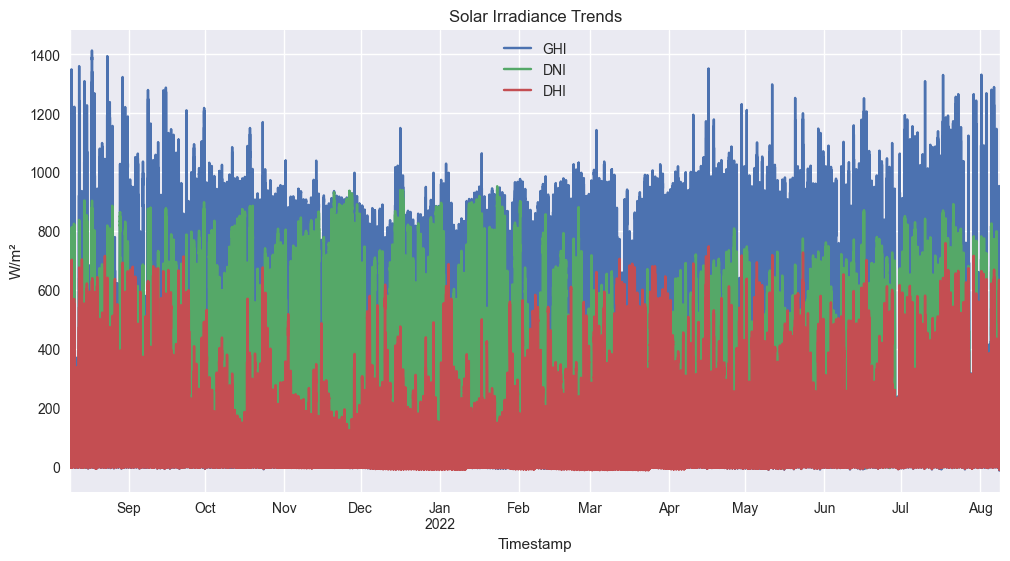

In [8]:
# Plot solar irradiance over time
df_clean.set_index("Timestamp")[["GHI", "DNI", "DHI"]].plot(figsize=(12, 6))
plt.title("Solar Irradiance Trends")
plt.ylabel("W/m²")
plt.show()

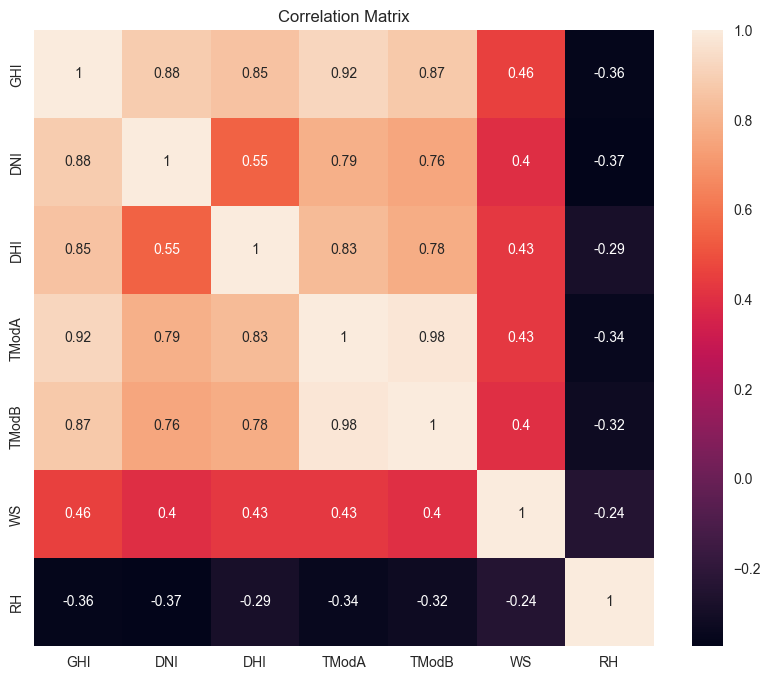

In [9]:
# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[["GHI", "DNI", "DHI", "TModA", "TModB", "WS", "RH"]].corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

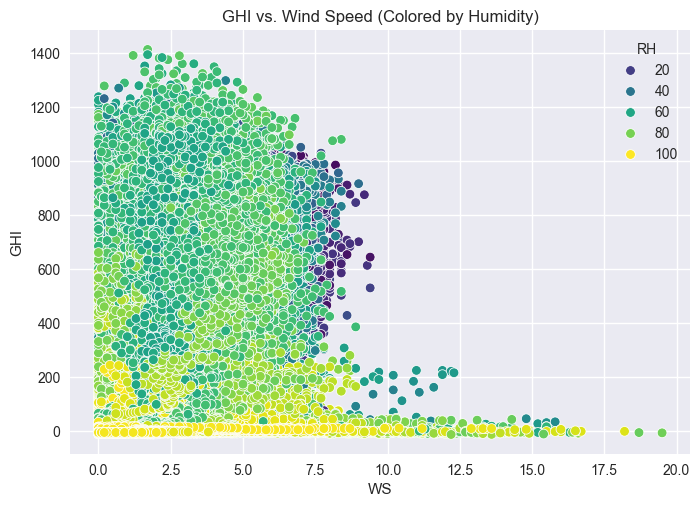

In [11]:
# Scatter plot: Wind speed vs. GHI
sns.scatterplot(data=df_clean, x="WS", y="GHI", hue="RH", palette="viridis")
plt.title("GHI vs. Wind Speed (Colored by Humidity)")
plt.show()

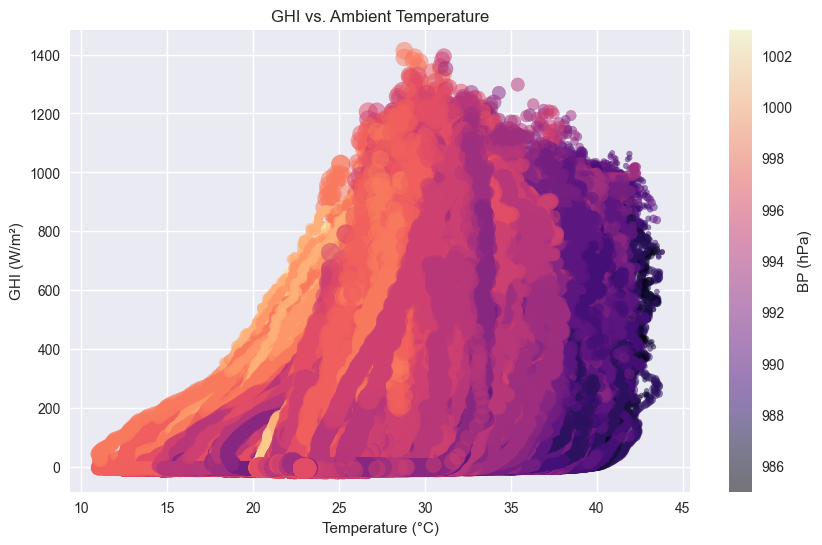

In [12]:
# Bubble chart: GHI vs. Temp (size=RH, color=BP)
plt.figure(figsize=(10, 6))
plt.scatter(
    x=df_clean["Tamb"], 
    y=df_clean["GHI"], 
    s=df_clean["RH"]*2,  # Bubble size
    c=df_clean["BP"],    # Color
    alpha=0.5,
    cmap="magma"
)
plt.colorbar(label="BP (hPa)")
plt.xlabel("Temperature (°C)")
plt.ylabel("GHI (W/m²)")
plt.title("GHI vs. Ambient Temperature")
plt.show()